In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import yaml

import sys
sys.path += ['../src/']
from utils import create_sparse_matrices, get_labeling_map

In [2]:
# 1. Define paths
with open("../scripts/parameters.yaml", 'r') as stream:
    parameters = yaml.safe_load(stream)
dataset_path = Path(parameters['dataset_path'])
input_path = Path(parameters['input_path'])
folder_results = Path(parameters['folder_results'])
score_file = input_path / Path('scores.big.csv')
subreddit_names = np.load(input_path / Path("list_subreddits.npy"), allow_pickle=True)
DIMENSIONS = ['year', 'gender', 'demo_rep']




def plot_subreddits_activity_distrib(X, y, dimension, index2label, savefig=False):
    # Sum of activity for each column
    column_activity = np.array(X.sum(axis=0)).flatten()

    # Get the indices of the top 10 columns
    top_10_indices = column_activity.argsort()[-10:][::-1]

    # Get the column names of the top 10 columns
    top_10_columns = subreddit_names[top_10_indices]

    # Get the activity of the top 10 columns for each class
    activity_class_0 = np.array(X[y == 0][:, top_10_indices].sum(axis=0)).flatten()
    activity_class_1 = np.array(X[y == 1][:, top_10_indices].sum(axis=0)).flatten()

    # Plotting the histogram
    bar_width = 0.35
    index = np.arange(len(top_10_columns))

    fig, ax = plt.subplots(figsize=(6, 4))
    bar1 = ax.bar(index, activity_class_0, bar_width, label=index2label[0])
    bar2 = ax.bar(index + bar_width, activity_class_1, bar_width, label=index2label[1])

    ax.set_xlabel('Subreddit')
    ax.set_ylabel('Activity')
    attribute = "partisan" if dimension == "demo_rep" else dimension
    ax.set_title(f'{attribute.capitalize()}')
    ax.set_xticks(index + bar_width / 2)
    ax.set_xticklabels(top_10_columns, rotation=45, ha='right')
    ax.grid(alpha=.25)
    ax.legend(loc='upper right', prop={'size': 11})
    sns.despine()

    if savefig:
        plt.savefig(f'../data/figures/activity_distribution_{dimension}.pdf', format='pdf', dpi=300, bbox_inches='tight')

    plt.tight_layout()
    plt.show()




---> DIMENSION: year
   number of declarations: 420803
   number of users: 401390
   number of non active users: 1630
   number of ambiguous users: 17341
    creating scipy matrices
      creating boolean X matrix: True


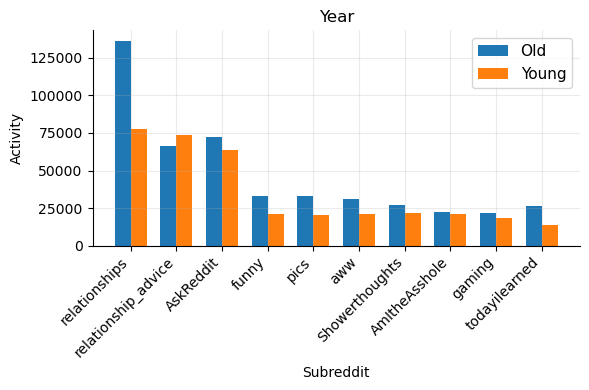



---> DIMENSION: gender
   number of declarations: 424330
   number of users: 403428
   number of non active users: 1634
   number of ambiguous users: 18337
    creating scipy matrices
      creating boolean X matrix: True


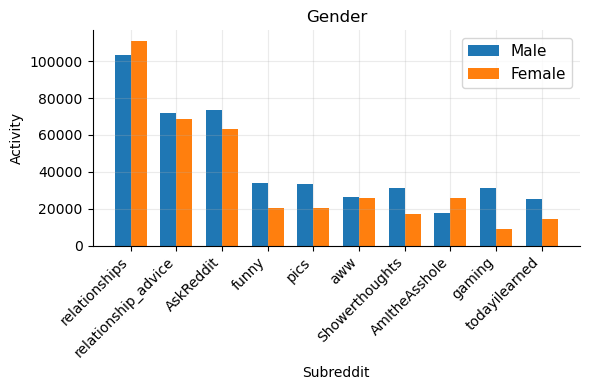



---> DIMENSION: demo_rep
   number of declarations: 6369
   number of users: 6118
   number of non active users: 4
   number of ambiguous users: 251
    creating scipy matrices
      creating boolean X matrix: True


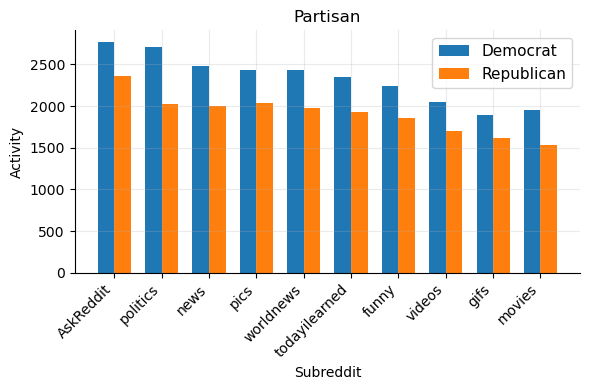

,Dimension,Declarations,Users,Non-active users,Ambiguous users,Class Proportion,Active subreddits
0,year,"420,803","401,390","1,630","17,341","old: 56.19%, young: 43.81%","9,806"
0,gender,"424,330","403,428","1,634","18,337","m: 50.89%, f: 49.11%","9,809"
0,partisan,"6,369","6,118",4,251,"democrat: 54.55%, republican: 45.45%","9,137"


In [4]:
dataframes = []

for dimension in DIMENSIONS:
    print(f"\n\n---> DIMENSION: {dimension}")

    if dimension == "year": index2label = {0: "Old", 1: 'Young'} 
    elif dimension == "age": index2label = {1: "Old", 0: 'Young'}
    elif dimension in ("gender", "demo_rep"): # Gender and Partisan
        label2index = get_labeling_map(dimension, fullname=True)
        index2label = {v: k for k, v in label2index.items()}
    else:
        raise Exception(dimension)

    y, X, data_stats = create_sparse_matrices(subreddit_names, True, dataset_path / Path(f"{dimension}__body"), save=False, verbose=True)
    data_stats['Dimension'] = 'partisan' if dimension == "demo_rep" else dimension
    dataframes.append(pd.DataFrame(data_stats))

    plot_subreddits_activity_distrib(X, y, dimension, index2label, savefig=True)





# Format table
df_dataset_description = pd.concat(dataframes)
df_dataset_description = df_dataset_description[['Dimension', 'Declarations', 'Users', 'Non-active users',	'Ambiguous users', 'Class Proportion', 'Active subreddits']]
for col in ['Declarations', 'Users', 'Non-active users', 'Ambiguous users', 'Active subreddits']:
    df_dataset_description[col] = df_dataset_description[col].apply(lambda x: f"{x:,}")

display(df_dataset_description)


# Save latex table
latex_table = df_dataset_description.to_latex(index=False, escape=False, column_format='c' * len(df_dataset_description.columns))

with open(f"../data/tables/dataset_stats.tex", 'w') as file:
    file.write(latex_table)